In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils.analysis_helpers import *
from bertopic import BERTopic

c:\Users\david\anaconda3\envs\topic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Define the Docs

In [3]:
df_all = pd.read_csv("segmented_sentences.csv")
# Rename Segmented_Sentence to Content
df_all = df_all.rename(columns={"Segmented_Sentence": "Content"})
df_all

,File Name,turn_index,Speaker,Experiment,Id,Condition,Full_Content,Content,Speaker_original
0,ID 05,0,Interviewer,OBE1,5,1,"No, don't worry, it's just...","no, don't worry, it's just...",Interviewer 1
1,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","so, that was very, let's say, unexpected and s...",Participant
2,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","i mean, at least that's what i felt, that i wa...",Participant
3,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...",and then i was observing it from above,Participant
4,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","and as i was saying, i felt at a specific mome...",Participant
...,...,...,...,...,...,...,...,...,...
2913,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,i know that's true when i felt like sending lo...,Participant
2914,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,i sent them to the person so maybe in both pla...,Participant
2915,S313,39,Participant,Compassion,313,1,I know that's true. When I felt like sending l...,"i didn't feel it was me, but i felt it was mys...",Participant
2916,S313,40,Interviewer,Compassion,313,1,"Okay, I see. The answers for my questions.",okay,Interviewer 2


In [4]:
# Preoprocessing
df = df_all.copy()
# Focus only on the participant's or interviewer's speech or both
#df = df[df["Speaker"] == "Participant"]
#df = df[df["Speaker"] == "Interviewer"]

# Select experiment
df = df[df["Experiment"] != "Compassion"]

# Filter tokens (stopwords, punctuations) were removed using the spacy library, 
# All text was lowercased + lemmatized,
# Plus extra_stopwords being the most frequents words in the corpus AND being meaningless 
extra_stopwords = [
    # Filler Words: Common conversational placeholders without thematic value
    "yeah", "okay", "yes", "mean", "oh", "ah", "like", "kind","kinda", "course", "way",
    # Vague/Ambiguous Words: Frequent but thematically irrelevant in conversations
    "think", "know", "really", "bit", "feel", "thing", "sort", "maybe", "little", "actually",
    "sure", "exactly", "tell", "ask", "people", "think",
    # Broad terms or context-specific words overshadowing subtler themes
    "question", "sorry", "time", "first", "second", "later", "experience", "end", "meditation","body"
]
df['preprocessed_content'] = df['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_stopwords, retain_stopwords=["yourself", "myself"]))

# Remove rows with empty content or content that's only punctuation after preprocessing
df = df[df['preprocessed_content'].str.strip().str.len() > 0]
# File S225 is removed because it is empty after preprocessing (only two utterances, not meaningful words for topics)
 # -> it was the Intervention condition, so mostly only discuss the sencond condition (control)

df.to_csv("preprocessed_content.csv", index=False)

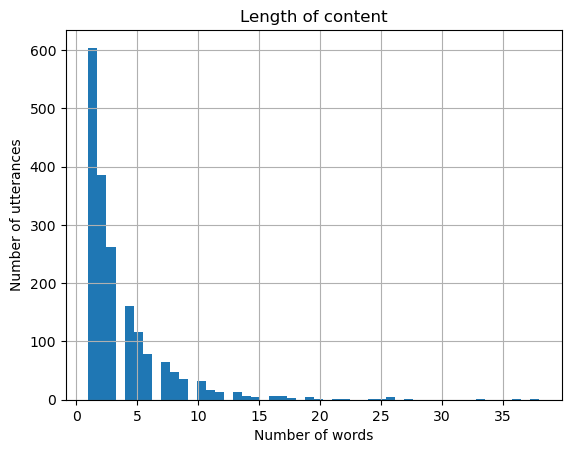

In [5]:
# See the length of the preprocessed content
df['preprocessed_content'].apply(lambda x: len(x.split())).hist(bins=50)
plt.title("Length of content")
plt.xlabel("Number of words")
plt.ylabel("Number of utterances")
plt.show()

In [6]:
# df = df.groupby(['File Name','turn_index']).agg({ 
#     'Content': ' '.join,  # Combine raw text
#     'preprocessed_content': ' '.join,  # Combine preprocessed text
#     'Experiment': 'first',   # Keep the first 
#     'Condition': 'first',   # Keep the first
#     'Id': 'first',   # Keep the first
#     'Speaker': 'first',   # Keep the first
# }).reset_index()
# df

In [7]:
docs = list(df.preprocessed_content)
print(len(docs))

1877


In [8]:
# look rows with a specific word in the column preprocessed_content
#df[df['preprocessed_content'].str.contains("course")]

# Define the model

In [9]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-mpnet-base-v2") # Better but slower: all-mpnet-base-v2 || Trade-off: all-MiniLM-L6-v2
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches: 100%|██████████| 59/59 [00:44<00:00,  1.31it/s]


In [10]:
from umap import UMAP
from hdbscan import HDBSCAN

# Dimensionality reduction model
umap_model = UMAP(n_neighbors=15, n_components=8, min_dist=0.0, metric='cosine', random_state=42)

# Clustering model
hdbscan_model = HDBSCAN(min_cluster_size=7, metric='euclidean', cluster_selection_method='eom')

topic_model = BERTopic(                     
# Pipeline models
embedding_model=embedding_model,
umap_model=umap_model,
hdbscan_model=hdbscan_model,
# Hyperparameters
verbose=True)

In [11]:
topics, ini_probs = topic_model.fit_transform(docs)
num_topics = len(topic_model.get_topics()) - 1
num_topics

2025-01-11 11:08:25,080 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 59/59 [00:22<00:00,  2.60it/s]
2025-01-11 11:08:47,839 - BERTopic - Embedding - Completed ✓
2025-01-11 11:08:47,839 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-11 11:09:04,792 - BERTopic - Dimensionality - Completed ✓
2025-01-11 11:09:04,793 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-11 11:09:04,936 - BERTopic - Cluster - Completed ✓
2025-01-11 11:09:04,951 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-11 11:09:05,125 - BERTopic - Representation - Completed ✓


89

In [12]:
topic_model.get_topic_info().to_csv("topic_model.csv")
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,374,-1_start_dream_outside_look,"[start, dream, outside, look, say, point, myse...",[zoom start look obviously current moment poin...
1,0,52,0_touch_touching_image_delay,"[touch, touching, image, delay, backside, help...","[touch, touch, touch]"
2,1,39,1_forest_tree_wind_rock,"[forest, tree, wind, rock, setting, bird, rive...","[forest, forest, forest]"
3,2,36,2_eye_close_open_prefer,"[eye, close, open, prefer, scan, closed, follo...","[close eye, close eye, eye close eye open]"
4,3,36,3_image_pixel_clear_fact,"[image, pixel, clear, fact, mosaic, camera, pr...","[fact pixel, clear image yourself, image real ..."
...,...,...,...,...,...
85,84,8,84_sensation_additional_overwhelm_bodily,"[sensation, additional, overwhelm, bodily, fea...",[sensation afraid intense overwhelming able co...
86,85,8,85_meditate_eye_open_close,"[meditate, eye, open, close, suddenly, usually...","[meditate meditate close eye strange, meditate..."
87,86,8,86_beginning_half_begin_start,"[beginning, half, begin, start, pretty, stuff,...","[beginning, beginning, beginning]"
88,87,7,87_love_dot_location_miss,"[love, dot, location, miss, twin, sister, life...","[love, love, love location]"


In [13]:
# # Reduce outliers with pre-calculate embeddings
# new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings", embeddings=embeddings)
# topic_model.update_topics(docs, topics=new_topics)
# topics = new_topics

# # Display new topics
# topic_model.get_topic_info()

In [14]:
topic_model.visualize_barchart(top_n_topics=16)

In [15]:
topic_model.visualize_topics()

In [16]:
#topic_model.visualize_heatmap(n_clusters = num_topics-1)

In [17]:
#topics_per_class = topic_model.topics_per_class(docs, classes=df.Id)
#topic_model.visualize_topics_per_class(topics_per_class)

In [18]:
#topics_per_class

In [19]:
#hierarchical_topics = topic_model.hierarchical_topics(docs)
#topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [20]:
df['one_topic'] = topics
topic_name_to_id = dict(zip(topic_model.get_topic_info().Topic, topic_model.get_topic_info().Name))
df['one_topic_name'] = df['one_topic'].map(topic_name_to_id)

df.to_csv("df_topic_single.csv", index = False)

In [21]:
topic_name_to_id

{-1: '-1_start_dream_outside_look',
 0: '0_touch_touching_image_delay',
 1: '1_forest_tree_wind_rock',
 2: '2_eye_close_open_prefer',
 3: '3_image_pixel_clear_fact',
 4: '4_strange_weird_funny_weirdness',
 5: '5_relaxed_stress_relax_relief',
 6: '6_vr_virtual_mirror_reality',
 7: '7_want_glass_prefer_option',
 8: '8_good_perfect_great_bad',
 9: '9_absolutely_positive_noticeable_definitely',
 10: '10_sleepy_asleep_fall_sleep',
 11: '11_moment_emotion_ground_specific',
 12: '12_different_depend_process_everyday',
 13: '13_nice_great_thank_perfect',
 14: '14_mind_wander_imagine_mental',
 15: '15_interesting_well_thit_underneath',
 16: '16_color_yellow_change_signal',
 17: '17_normal_normally_natural_limit',
 18: '18_concentrate_focus_distract_forget',
 19: '19_particle_blink_dark_change',
 20: '20_blink_avatar_blinking_synchronize',
 21: '21_experiment_flash_point_stage',
 22: '22_sit_chair_bag_stand',
 23: '23_feeling_mix_spot_highly',
 24: '24_case_observe_watch_observation',
 25: '25_i

# Topic Distribution (More than one topic per docs) 
- To reduce the numbers of outliers and avoid False Positive (Interesting when looking at one specif topic)

### Look similarities

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 

distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))
dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(), 
                       index=topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]
pair_dist_df.sort_values('distance', ascending = False).head(20)

,topic1,topic2,distance
356,2_eye_close_open_prefer,85_meditate_eye_open_close,0.808012
1765,18_concentrate_focus_distract_forget,54_focus_focused_tooth_care,0.757708
3681,39_realise_spiritual_state_attached,80_emotion_dress_wave_safe,0.753979
3786,41_calm_worry_relax_cry,5_relaxed_stress_relax_relief,0.740612
1318,13_nice_great_thank_perfect,57_cool_afar_pretty_add,0.727456
1390,14_mind_wander_imagine_mental,39_realise_spiritual_state_attached,0.711189
2709,29_fine_ok_ready_alright,8_good_perfect_great_bad,0.708038
2245,23_feeling_mix_spot_highly,84_sensation_additional_overwhelm_bodily,0.707595
3653,39_realise_spiritual_state_attached,52_yourself_viewpoint_outside_see,0.694345
1209,12_different_depend_process_everyday,38_difference_comparison_comparable_compare,0.674704


### Multiples topics

In [23]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(
      docs, window = 5, calculate_tokens=True)

100%|██████████| 2/2 [00:00<00:00, 24.66it/s]


In [24]:
import tqdm
import plotly.express as px

tmp_dfs = []

# iterating through different threshold levels
for thr in tqdm.tqdm(np.arange(0, 0.35, 0.001)):
    # calculating number of topics with probability > threshold for each document
    tmp_df = pd.DataFrame(list(map(lambda x: len(list(filter(lambda y: y >= thr, x))), topic_distr))).rename(
        columns = {0: 'num_topics'}
    )
    tmp_df['num_docs'] = 1
    
    tmp_df['num_topics_group'] = tmp_df['num_topics']\
        .map(lambda x: str(x) if x < 5 else '5+')
    
    # aggregating stats
    tmp_df_aggr = tmp_df.groupby('num_topics_group', as_index = False).num_docs.sum()
    tmp_df_aggr['threshold'] = thr
    
    tmp_dfs.append(tmp_df_aggr)

num_topics_stats_df = pd.concat(tmp_dfs).pivot(index = 'threshold', 
                              values = 'num_docs',
                              columns = 'num_topics_group').fillna(0)

num_topics_stats_df = num_topics_stats_df.apply(lambda x: 100.*x/num_topics_stats_df.sum(axis = 1))

# visualisation
colormap = px.colors.sequential.YlGnBu
px.area(num_topics_stats_df, 
       title = 'Distribution of number of topics',
       labels = {'num_topics_group': 'number of topics',
                'value': 'share of reviews, %'},
       color_discrete_map = {
          '0': colormap[0],
          '1': colormap[3],
          '2': colormap[4],
          '3': colormap[5],
          '4': colormap[6],
          '5+': colormap[7]
      })

100%|██████████| 350/350 [24:55<00:00,  4.27s/it]   


In [25]:
threshold = 0.2

# define topic with probability > threshold for each document
df['multiple_topics'] = list(map(
    lambda doc_topic_distr: list(map(
        lambda y: y[0], filter(lambda x: x[1] >= threshold, 
                               (enumerate(doc_topic_distr)))
    )), topic_distr
))

# creating a dataset with docid, topic
tmp_data = []

for rec in df.to_dict('records'):
    if len(rec['multiple_topics']) != 0:
        mult_topics = rec['multiple_topics']
    else:
        mult_topics = [-1]
        
    for topic in mult_topics: 
        tmp_data.append(
            {
                'topic': topic,
                'id': rec['Content'],
            }
        )
            
mult_topics_df = pd.DataFrame(tmp_data)
df["multiple_topics_name"] = df["multiple_topics"].map(lambda x: [topic_name_to_id.get(i, "No topic") for i in x])


In [26]:
df.to_csv("df_topic_multiples.csv", index = False)
df.head()

,File Name,turn_index,Speaker,Experiment,Id,Condition,Full_Content,Content,Speaker_original,preprocessed_content,one_topic,one_topic_name,multiple_topics,multiple_topics_name
0,ID 05,0,Interviewer,OBE1,5,1,"No, don't worry, it's just...","no, don't worry, it's just...",Interviewer 1,worry,41,41_calm_worry_relax_cry,"[41, 48]","[41_calm_worry_relax_cry, 48_notice_change_own..."
1,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","so, that was very, let's say, unexpected and s...",Participant,let unexpected surprising moment go realize ge...,30,30_disconnected_disconnect_disconnection_detach,"[11, 30]","[11_moment_emotion_ground_specific, 30_disconn..."
2,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","i mean, at least that's what i felt, that i wa...",Participant,get disconnected basically stay,30,30_disconnected_disconnect_disconnection_detach,"[30, 69]",[30_disconnected_disconnect_disconnection_deta...
3,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...",and then i was observing it from above,Participant,observe,24,24_case_observe_watch_observation,"[24, 74]","[24_case_observe_watch_observation, 74_observe..."
4,ID 05,1,Participant,OBE1,5,1,"So, that was very, let's say, unexpected and s...","and as i was saying, i felt at a specific mome...",Participant,say specific moment lot emotion come,11,11_moment_emotion_ground_specific,"[11, 80]","[11_moment_emotion_ground_specific, 80_emotion..."


### Look differences btw single and multiple topics

In [27]:
topic_name_to_id

{-1: '-1_start_dream_outside_look',
 0: '0_touch_touching_image_delay',
 1: '1_forest_tree_wind_rock',
 2: '2_eye_close_open_prefer',
 3: '3_image_pixel_clear_fact',
 4: '4_strange_weird_funny_weirdness',
 5: '5_relaxed_stress_relax_relief',
 6: '6_vr_virtual_mirror_reality',
 7: '7_want_glass_prefer_option',
 8: '8_good_perfect_great_bad',
 9: '9_absolutely_positive_noticeable_definitely',
 10: '10_sleepy_asleep_fall_sleep',
 11: '11_moment_emotion_ground_specific',
 12: '12_different_depend_process_everyday',
 13: '13_nice_great_thank_perfect',
 14: '14_mind_wander_imagine_mental',
 15: '15_interesting_well_thit_underneath',
 16: '16_color_yellow_change_signal',
 17: '17_normal_normally_natural_limit',
 18: '18_concentrate_focus_distract_forget',
 19: '19_particle_blink_dark_change',
 20: '20_blink_avatar_blinking_synchronize',
 21: '21_experiment_flash_point_stage',
 22: '22_sit_chair_bag_stand',
 23: '23_feeling_mix_spot_highly',
 24: '24_case_observe_watch_observation',
 25: '25_i

In [28]:
# look for a specific topic the topic 12
specific_topic = df[df['one_topic'] == 12]
print(len(specific_topic))
# look at specifc columns
specific_topic[['Experiment','Id','Condition','Speaker','Content','multiple_topics_name']]

28


,Experiment,Id,Condition,Speaker,Content,multiple_topics_name
176,OBE1,14,1,Participant,"yes, different parts of the body, yeah",[12_different_depend_process_everyday]
210,OBE1,15,1,Participant,so this was a little bit different,[12_different_depend_process_everyday]
310,OBE1,18,1,Interviewer,"was it different, harder, easier?","[12_different_depend_process_everyday, 61_diff..."
359,OBE1,19,I,Participant,yeah that's different,[12_different_depend_process_everyday]
456,OBE1,22,1,Participant,yeah i don't i don't think i felt something di...,[12_different_depend_process_everyday]
759,OBE2,201,I,Participant,it's different it's different,[12_different_depend_process_everyday]
812,OBE2,201,I,Interviewer,"well, it can be different, depending on how mu...","[12_different_depend_process_everyday, 28_move..."
839,OBE2,201,I,Interviewer,"if i get what you're saying, it seems that for...","[12_different_depend_process_everyday, 38_diff..."
872,OBE2,202,1,Participant,different from the everyday life,[12_different_depend_process_everyday]
885,OBE2,202,1,Interviewer,"i mean, it is a bit different, because in the ...","[12_different_depend_process_everyday, 32_your..."


In [29]:
# look for a specific topic the topic 12
specific_topic = df[df['multiple_topics'].map(lambda x: 12 in x)]
print(len(specific_topic))
# look at specifc columns
specific_topic[['Experiment','Id','Condition','Speaker','Content','multiple_topics_name']]

56


,Experiment,Id,Condition,Speaker,Content,multiple_topics_name
176,OBE1,14,1,Participant,"yes, different parts of the body, yeah",[12_different_depend_process_everyday]
210,OBE1,15,1,Participant,so this was a little bit different,[12_different_depend_process_everyday]
310,OBE1,18,1,Interviewer,"was it different, harder, easier?","[12_different_depend_process_everyday, 61_diff..."
350,OBE1,19,I,Interviewer,"and the open eyes, was it different then?","[2_eye_close_open_prefer, 12_different_depend_..."
359,OBE1,19,I,Participant,yeah that's different,[12_different_depend_process_everyday]
396,OBE1,19,C,Interviewer,"yeah actually yeah it's really, we want to obs...","[12_different_depend_process_everyday, 25_inst..."
437,OBE1,22,1,Participant,because in the previous session with the four ...,"[12_different_depend_process_everyday, 51_plat..."
456,OBE1,22,1,Participant,yeah i don't i don't think i felt something di...,[12_different_depend_process_everyday]
599,OBE1,7,I,Participant,"it depends on how you are as it is alive, you ...","[12_different_depend_process_everyday, 28_move..."
759,OBE2,201,I,Participant,it's different it's different,[12_different_depend_process_everyday]
